In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import copy

In [3]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Test Gym Environment Specs and Visualization

Action Space--> Box(-1.0, 1.0, (2,), float32)
Observation Space--> Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
reward range--> (-inf, inf)
Meta data -->  {'render_modes': ['human', 'rgb_array'], 'render_fps': 50}
Specifications --> EnvSpec(id='LunarLander-v2', entry_point='gymnasium.envs.box2d.lunar_lander:LunarLander', reward_threshold=200, nondeterministic=False, max_episode_steps=1000, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'continuous': True, 'gravity': -10.0, 'enable_wind': False, 'wind_power': 15.0, 'turbulence_power': 1.5, 'render_mode': 'rgb_array'}, namespace=None, name='LunarLander', version=2, additional_wrappers=(), vector_entry_point=None)


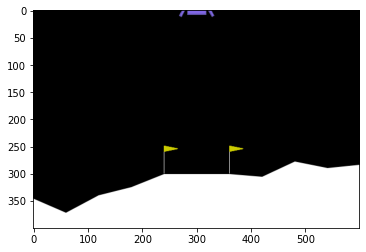

In [20]:
env = gym.make("LunarLander-v2", continuous = True, gravity = -10.0, enable_wind = False, wind_power = 15.0, turbulence_power = 1.5, render_mode='rgb_array')
print('Action Space-->',env.action_space)
print('Observation Space-->',env.observation_space)
print('reward range-->',env.reward_range)
print('Meta data --> ',env.metadata)
print('Specifications -->',env.spec)
env.reset()

prev_screen = env.render()
plt.imshow(prev_screen)


In [25]:
def animate(imgs, _return=True):
    import cv2
    import os
    import string
    import random
    
    
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
    

In [ ]:
# Test and visualize the agent with random actions
frames = []
for i in range(200):
    frames.append(env.render())
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        env.reset()
        
env.close()

In [26]:
animate(frames)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


# Replay Buffer

In [27]:

#Experience Replay Buffer
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

# Ornstein Ulhenbeck (OU) noise

In [28]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.randn() for i in range(len(x))])
        self.state = x + dx
        return self.state

# Actor Critic Networks

In [29]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, action_max):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        self.action_max = action_max
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return torch.tanh(self.output(x)) * self.action_max
    
class CriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size+action_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x, a):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(torch.cat((x,a),dim=1)))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

# Agent

In [30]:
class DDPGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, critic_lr, discount,
                 min_action, max_action, exploration_noise):
        self.action_size = action_size
        self.actor = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.actor_target = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.critic = CriticNet(state_size, action_size, hidden_size).to(device)
        self.critic_target = CriticNet(state_size, action_size, hidden_size).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.discount = discount
        self.min_action = min_action
        self.max_action = max_action
        self.exploration_noise = exploration_noise
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action = self.actor(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action = action.detach().cpu().numpy()
            #in DDPG add noise for exploration
            #action = (action + np.random.normal(0., self.exploration_noise, size=self.action_size)).clip(self.min_action, self.max_action)   
            self.ou_noise = OUNoise(action_size)
            action += self.ou_noise.sample()
            action.clip(self.min_action, self.max_action)  
        return action

    
    def train(self, replay_buffer, batch_size):
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and use GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.FloatTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        flipped_done_batch = torch.FloatTensor(d).to(device) #already flipped done when adding to replay buffer

        # get target net target values
        with torch.no_grad():
            target_action = self.actor_target(next_state_batch).view(batch_size,-1)
            target_v = reward_batch + flipped_done_batch*self.discount*self.critic_target(next_state_batch, 
                                                                           target_action).view(batch_size,-1)
        # get train net values for updating the critic network    
        critic_v = self.critic(state_batch, action_batch).view(batch_size,-1)
        
        # train critic
        critic_loss = F.smooth_l1_loss(critic_v, target_v)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step() 
        
        # train actor
        train_action = self.actor(state_batch)
        actor_loss = -torch.mean(self.critic(state_batch,train_action))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()
        
        
    def update_target_network_soft(self, num_iter, update_every, update_tau=0.001):
        # soft target network update: update target networks with mixture of train and target
        if num_iter % update_every == 0:
            for target_var, var in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)
            for target_var, var in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)


# Hyperparameter

In [31]:
# set seed
seed = 30
env.reset(seed=seed)# new 
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
# create replay buffer
replay_size = 50000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)    

# target update hyperparameters
start_training_after = 10001 # start training NN after this many timesteps
update_target_every = 5 # update target network every this steps
tau = 0.001

episodes = 1000    
discount = 0.99
batch_size = 32
exploration_noise = 0.1 #NOISE
hidden_size = 64
actor_lr = 0.0005
critic_lr = 0.0005
reward_scale = 0.01

In [32]:
env = gym.make("LunarLander-v2", continuous = True, gravity = -10.0, enable_wind = False, wind_power = 15.0, turbulence_power = 1.5, render_mode='rgb_array')
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]

In [33]:
agent = DDPGAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size, 
                  actor_lr=actor_lr, critic_lr=critic_lr, discount=discount, min_action=min_action,
                  max_action=max_action, exploration_noise=exploration_noise)

# Training

In [35]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state, info = env.reset()

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        # next_state, reward, done, _ = env.step(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_length += 1
        # end episode early
        if total_reward < -250:
            terminated = 1
        
        # add experience to replay buffer
        replay_buffer.add((state, next_state, action, reward*reward_scale, 1-float(terminated)))
        
        # train the agent
        if timesteps >= start_training_after:
            actor_loss, critic_loss = agent.train(replay_buffer, batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft(timesteps, update_target_every)
            
        if terminated:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if timesteps >= start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                    'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break
        
        state = next_state

Episode: 100 Timestep: 10064 Total reward: -158.0 Episode length: 92.7 Actor Loss: 0.1678 Critic Loss: 0.0034
Episode: 110 Timestep: 10484 Total reward: -256.1 Episode length: 42.0 Actor Loss: 0.1553 Critic Loss: 0.0041
Episode: 120 Timestep: 10927 Total reward: -257.4 Episode length: 44.3 Actor Loss: 0.1558 Critic Loss: 0.0032
Episode: 130 Timestep: 11502 Total reward: -255.7 Episode length: 57.5 Actor Loss: 0.1553 Critic Loss: 0.0031
Episode: 140 Timestep: 13192 Total reward: -239.5 Episode length: 169.0 Actor Loss: 0.1473 Critic Loss: 0.0023
Episode: 150 Timestep: 14778 Total reward: -173.1 Episode length: 158.6 Actor Loss: 0.1363 Critic Loss: 0.0019
Episode: 160 Timestep: 18882 Total reward: -206.7 Episode length: 410.4 Actor Loss: 0.1302 Critic Loss: 0.0014
Episode: 170 Timestep: 20524 Total reward: -267.1 Episode length: 164.2 Actor Loss: 0.1288 Critic Loss: 0.0013
Episode: 180 Timestep: 21924 Total reward: -260.8 Episode length: 140.0 Actor Loss: 0.1290 Critic Loss: 0.0012
Episo

Text(0, 0.5, 'Episode Reward')

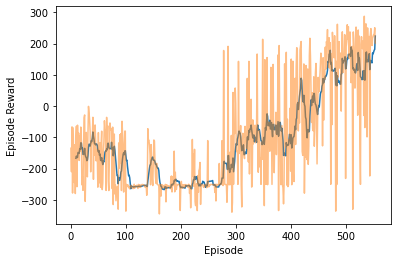

In [36]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

# Testing

In [37]:
def plot_episode(env, agent):
    state, info = env.reset()
    frames = []
    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)
        state = next_state
        if terminated:
            break
    return frames

In [38]:
test_env = gym.make('LunarLander-v2', continuous=True, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='rgb_array')

In [39]:
frames = plot_episode(test_env, agent)

In [40]:
animate(frames)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'
